In [ ]:
import sys
!{sys.executable} -m pip install pymoo  # For ipopt solver

# Install a pip package in the current Jupyter kernel

from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

restartkernel()

In [1]:
import os
from spyci import spyci
import matplotlib.pyplot as plt
%matplotlib inline

# Write a file 4th_order_rc_test.spice

In [2]:
%%writefile inv.spice
********Digital inverter**********
.PARAM WP = 1.5e-6
.PARAM LMIN = 0.39e-6
.PARAM VD = 3.3
**--**--**--**--**--**--**--**--**--**

*** *** SUPPLY VOLTAGES *** ***
VDD VDD 0 {VD}
VSS VSS 0 0
VIN IN  0 1

*** *** CIRCUIT *** ***
MP OUT IN VDD VDD PM W={WP}    L={LMIN} pd={2*WP}   ps={2*WP}
MN OUT IN VSS VSS NM W={WP/3}  L={LMIN} pd={2/3*WP} ps={2/3*WP}
CL OUT VSS 12p

*** *** ANALYSIS *** ***

.options savecurrents
.include b3.typ

.control
set color0 =white
set filetype = ascii
dc VIN 0 3.3 0.01
*plot OUT @mn[id]*20000

meas dc switch_point find out WHEN v-sweep=1.65 CROSS=LAST
meas dc i_max    MAX    @mn[id] 
meas dc i_max_at MAX_AT @mn[id]

print switch_point i_max i_max_at

write inv.raw OUT @mn[id] switch_point i_max i_max_at
.endc

.END

Overwriting inv.spice


In [3]:
filename="inv.raw"
data = spyci.load_raw(filename)  # see 'Data structure' section below
spyci.list_vars(filename)

Variables:

  idx  name          type
-----  ------------  -------------
    1  v(out)        voltage
    2  i(@mn[id])    current
    3  switch_point  notype dims=1
    4  i_max         notype dims=1
    5  i_max_at      notype dims=1


In [4]:
def add_param_lines(file_path, param_names_and_values):
    
  if not os.path.exists(file_path):
    raise FileNotFoundError("File does not exist: {}".format(file_path))

  with open(file_path, "r") as f:
    lines = f.readlines()

  first_line = lines[0]

  param_lines = []
  for param_name, param_value in param_names_and_values:
    param_lines.append(".PARAM {} = {}\n".format(param_name, param_value))

  # Find the index of the line with the text `"**--**--**--**--**--**--**--**--**--**\n`
  recognizer="**--**--**--**--**--**--**--**--**--**\n"
  try:
      index = lines.index(recognizer)
      new_lines = [first_line] + param_lines + [recognizer] + lines[index + 1:]
  except ValueError:
      new_lines = [first_line] + param_lines + [recognizer] + lines[1:]

  with open(file_path, "w") as f:
    f.writelines(new_lines)


In [5]:
def get_values(filename, pvars=None):
    """
    Load the values from a SPICE raw file and return a list of arrays.

    Args:
        filename (str): The path to the SPICE raw file.
        pvars (list): A list of string variables to load. If None, all variables are loaded.

    Returns:
        list: A list of arrays, one for each variable in pvars.
    """

    d = spyci.load_raw(filename)
    xx = []
    for var in pvars:
        xx.append(d['values'][var].real)
    return xx

# Test the add_param_function

In [6]:
filename = "inv.spice"
param_names_and_values = [
    
    ["WP",   1.8e-6], 
    ["LMIN", 0.39e-6],
    ["VD",   3.3]
    
    ]
add_param_lines(filename, param_names_and_values)

# View the contents

In [ ]:
r=os.system("cat inv.spice")

# Test the get_values function

In [7]:
get_values("inv.raw",['switch_point'])


[array([0.5718124, 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.      

In [8]:
import os
def run_spice_again(x,filename,var_to_output):
    param_names_and_values = [
    
        ["WP",   x[0]], 
        ["LMIN", x[1]], 
        ["VD",  3.3]
        ]
    add_param_lines(filename, param_names_and_values)
    
    os.system("ngspice -b inv.spice -o .log > .log")
#     os.system("rm -f .temp")
    filename="inv.raw"
    data = spyci.load_raw(filename)  # see 'Data structure' section below
    output=get_values(filename,[var_to_output])[0][0]
#     print(switch_point)
    return output

print(run_spice_again([1.5e-6,0.35e-6],"inv.spice",'i_max'))

8.609826999999999e-05


In [9]:
import numpy as np
from pymoo.problems.functional import FunctionalProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

def find_values(n_var,x,range_l,range_u,objs,max_generations,verbose=True):

  # now put everything together to a problem object
  problem = FunctionalProblem(n_var,
                              objs,
                              # constr_ieq=constr_ieq,
                              xl=np.array(range_l),
                              xu=np.array(range_u)
                              )
    
#   F= problem.evaluate([x])
  
  ###########
  algorithm = NSGA2(
    pop_size=45,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=15),
    eliminate_duplicates=True
  )
  ##############
  termination = get_termination("n_gen", max_generations)
  ##############
  res = minimize(problem,
               algorithm,
               termination,
               seed=9,
               save_history=True,
               verbose=verbose)
  
  return res



In [10]:
#########################
range_l=[0.5e-6, 0.15e-6]
range_u=[8e-6, 4e-6]
target_switch_point=1.65
target_i_max_at=1.65
current_x=[1.8e-6,0.35e-6]## correct for 1000Hz
max_generations=50
verbose=True

# print(run_spice_again(current_x,"inv.spice"))
#########################COST_FUNCTION##########################################
cost_function = [
    lambda x: (run_spice_again(x,"inv.spice",'switch_point')-target_switch_point)**2, ####for the switchpoint of the inverter
    lambda x: (run_spice_again(x,"inv.spice",'i_max_at')-target_i_max_at)**2 ####for the switchpoint of the inverter
]
################################################################################

r=find_values(2,current_x,range_l,range_u,cost_function,max_generations,verbose=verbose)

result=r.X.T
result


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       45 |      2 |             - |             -
     2 |       55 |      2 |  0.000000E+00 |             f
     3 |       65 |      2 |  0.000000E+00 |             f
     4 |       75 |      1 |  0.3677082774 |         ideal
     5 |       85 |      1 |  0.000000E+00 |             f
     6 |       95 |      1 |  0.000000E+00 |             f
     7 |      105 |      1 |  0.0094449832 |         ideal
     8 |      115 |      2 |  1.0000000000 |         ideal
     9 |      125 |      2 |  0.000000E+00 |             f
    10 |      135 |      2 |  0.000000E+00 |             f
    11 |      145 |      2 |  0.000000E+00 |             f
    12 |      155 |      2 |  0.000000E+00 |             f
    13 |      165 |      2 |  0.7331013204 |         nadir
    14 |      175 |      2 |  0.000000E+00 |             f
    15 |      185 |      3 |  0.0142029969 |         ideal
    16 |      195 |      3 |  0.1382375279 |         nad

array([[4.46811650e-06, 3.91095547e-06],
       [4.51185029e-07, 4.77017867e-07]])

In [11]:
errors=[]
for index in range(len(result[0])):
    WP_opt=result[0][index]  #1kOhm
    LMIN_opt=result[1][index]  # 1µF

    obtained_switch_point=run_spice_again([WP_opt,LMIN_opt],"inv.spice",'switch_point')
    obtained_imax_point=run_spice_again([WP_opt,LMIN_opt],"inv.spice",'i_max_at')
    error=(((0.5*(obtained_switch_point+obtained_imax_point))-target_switch_point)*100/target_switch_point)
    errors.append(abs(error))
    print("========================================")
    print("Percentage Error is: {:7.4f} %".format(error))
    print("Target switch_point: {:7.3f} V".format(target_switch_point))
    print("Obtained switch_point(Optimized value ) is: {:7.3f} V".format(obtained_switch_point))
    print("Obtained imax_point(Optimized value ) is: {:7.3f} V".format(obtained_imax_point))    
    print("Width WP(Optimized value ) is: {:7.3f} um".format(WP_opt*1e6))
    print("Length LMIN(Optimized value ) is: {:7.3f} um".format(LMIN_opt*1e6))
    print("========================================")
    print()
best_case_index=errors.index(min(errors))
WP_opt=result[0][best_case_index]  #1kOhm
LMIN_opt=result[1][best_case_index]  # 1µF
obtained_switch_point=run_spice_again([WP_opt,LMIN_opt],"inv.spice",'switch_point')

Percentage Error is:  0.2685 %
Target switch_point:   1.650 V
Obtained switch_point(Optimized value ) is:   1.649 V
Obtained imax_point(Optimized value ) is:   1.660 V
Width WP(Optimized value ) is:   4.468 um
Length LMIN(Optimized value ) is:   0.451 um

Percentage Error is: -6.5331 %
Target switch_point:   1.650 V
Obtained switch_point(Optimized value ) is:   1.434 V
Obtained imax_point(Optimized value ) is:   1.650 V
Width WP(Optimized value ) is:   3.911 um
Length LMIN(Optimized value ) is:   0.477 um



# See the Optimized Values after best case selection

In [12]:
r=os.system("cat inv.spice")

********Digital inverter**********
.PARAM WP = 4.468116503408509e-06
.PARAM LMIN = 4.511850293170345e-07
.PARAM VD = 3.3
**--**--**--**--**--**--**--**--**--**

*** *** SUPPLY VOLTAGES *** ***
VDD VDD 0 {VD}
VSS VSS 0 0
VIN IN  0 1

*** *** CIRCUIT *** ***
MP OUT IN VDD VDD PM W={WP}    L={LMIN} pd={2*WP}   ps={2*WP}
MN OUT IN VSS VSS NM W={WP/3}  L={LMIN} pd={2/3*WP} ps={2/3*WP}
CL OUT VSS 12p

*** *** ANALYSIS *** ***

.options savecurrents
.include b3.typ

.control
set color0 =white
set filetype = ascii
dc VIN 0 3.3 0.01
*plot OUT @mn[id]*20000

meas dc switch_point find out WHEN v-sweep=1.65 CROSS=LAST
meas dc i_max    MAX    @mn[id] 
meas dc i_max_at MAX_AT @mn[id]

print switch_point i_max i_max_at

write inv.raw OUT @mn[id] switch_point i_max i_max_at
.endc

.END


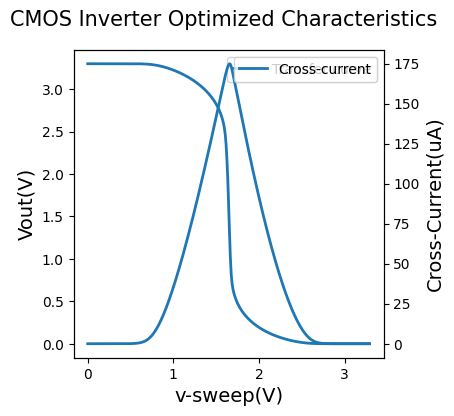

In [13]:
values=get_values("inv.raw",['i(@mn[id])','v(out)','switch_point','i_max','i_max_at'])
v_sweep=np.arange(0, 3.3, 3.3/len(values[1]))

fig, ax1 = plt.subplots(figsize=(4, 4))
ax2 = ax1.twinx()
fig.suptitle("CMOS Inverter Optimized Characteristics", fontsize=15)
ax1.set_xlabel("v-sweep(V)", fontsize=14)
ax2.set_ylabel("Cross-Current(uA)", fontsize=14)

ax1.set_ylabel("Vout(V)", fontsize=14)
ax2.plot(v_sweep,values[0]*1e6, lw=2,label ='Cross-current')
ax1.plot(v_sweep,values[1], lw=2,label ='Transfer curve')
leg=ax2.legend(loc ="upper right")
leg=ax1.legend(loc ="upper right")